# Lab 7 - Examining Feature Spaces with PCA

## Alex Isbill, Marvin Chan

## Background

In class, we talked about how machine learning techniques require vectors, and you must first perform **feature extraction** to create **feature vectors** if your data is not already in vector form. I mentioned that this is considered outside the domain of machine learning, but that's not entirely true, especially in recent years. In fact, most modern ML techniques that work on data that's not naturally represented as vectors (e.g., text, images, audio) begin with a very simple vector representation of the raw signal, then **learn** how to extract good features from them.

For example, in computer vision we used to start by detecting corners, edges, or other low-level visual features in images, then shoehorn those into vectors, which we would then use machine learning to classify. Nowadays, we typically flatten the image into a vector (pretty much just `np.flatten`) and use models that learn how to go from raw pixels to the answers we want.

An early example of such a model is called LeNet, and it was designed to work on the handwritten digit recognition problem that we briefly touched on in class. This model works in **layers**, where each layer transforms the image into a new set of features, until finally the last layer spits out a classification; in our case, it's trying to decide which of `range(10)` a handwritten digit represents. Here's a diagram of LeNet- the details aren't important, so don't worry about the specifics - but notice that the model is drawn in layers: ![](lenet5.png)

When trained well, the practical effect of models like this (these are called "convolutional neural networks", by the way) is that **the features become more and more "well-organized" after each layer**. Unfortunately, each intermediate feature representation is high-dimensional, so we can't directly see this. One of the uses we discussed in class for PCA is for visualizing high-dimensional things. In this lab, we're going to put this to use to visualize the the features at each step and see if we observe a trend towards a more orderly set of features.

Let's get some useful imports out of the way - if you need more libraries, import them here:

In [12]:
import numpy as np
import pandas as pd
import requests
import io
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

## The Data

For our purposes, the code for the LeNet model can be abstracted to something like this:

```python
inputs = load_digits()
conv1_features = conv1(inputs)
conv2_features = conv2(conv1_features)
fc1_features = fc1(conv2_features)
fc2_features = fc2(fc1_features)
fc3_features = fc3(fc2_features)
```

The specifics of the functions aren't important to us right now. Notice that each function simply takes the output of the prior one, and transforms it in some way to produce the next set of features.

Let's load up two files that give us access to those variables above, as well as the ground-truth digit labels, for 5400 example digits:

In [13]:
# adapted from https://stackoverflow.com/a/61716809
def np_load_from_url(url):
    response = requests.get(url)
    response.raise_for_status() # throw an error if it didn't work
    return np.load(io.BytesIO(response.content))

In [14]:
base_url = "https://facultyweb.cs.wwu.edu/~wehrwes/courses/data311_21f/data/mnist/"
labels = np_load_from_url(base_url + "labels.npz")["labels"]
features = dict(np_load_from_url(base_url + "features.npz"))

In [15]:
print(labels.shape, labels[:10])

(5400,) [1 5 6 5 2 0 0 8 1 7]


We can see that there are 5400 labels, and each one says what digit a given example actually represents.

In [16]:
print(features.keys())

dict_keys(['input', 'conv1', 'conv2', 'fc1', 'fc2', 'fc3'])


The `features` dict contains values for each of the variables described in the pseudocode above. The `input` just contains the input images, flattened into vectors:

In [17]:
features["input"].shape

(5400, 784)

Notice this is, as per tradition, an $n \times d$ matrix - each of 5400 images have 784 pixels (originally, they were 28x28). We can visualize a few images to see what they look like:

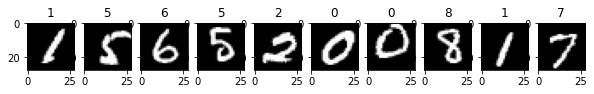

In [18]:
fig = plt.figure(figsize=(10, 4))
for i in range(10):
    plt.subplot(1,10,i+1)
    in_image = features["input"][i].reshape((28, 28))
    plt.imshow(in_image, cmap="gray")
    plt.title(str(labels[i]))

Notice the labels (above each image) line up with the labels we saw above.

The remaining features don't have such a nice visualizeable interpretation - we're stuck just thinking of them as high-dimensional vectors. Let's see their dimensionality:

In [19]:
pd.DataFrame({"Feature set" : features.keys(),
              "Shape": [f.shape for f in features.values()]})

,Feature set,Shape
0,input,"(5400, 784)"
1,conv1,"(5400, 3456)"
2,conv2,"(5400, 1024)"
3,fc1,"(5400, 120)"
4,fc2,"(5400, 84)"
5,fc3,"(5400, 10)"


## Your Tasks

#### Part 1: Visualizing the Feature Spaces

**1.1**: Your first (and primary) job in part 1 is to take each of these collections of feature vectors (I'll call them "feature sets" from here on out), use PCA to reduce their dimensionality to two, transform the features into their 2D representation, and visualize them in a scatterplot; color-code the points in the scatterplot by the ground-truth label (stored in `labels`).

##### PCA Refresher
Recall that you can compute PCA using `scikit-learn` by instantiating a `PCA` object, passing it the number of components you want to fit:
```python
pca = PCA(n_components=d_prime)
```
then calling its `fit` method on the $n \times d$ data matrix:
```python
pca.fit(X)
```

This computes the `d_prime` component vectors that point in the directions of greatest variance, accessible via `pca.components_`. To actually reduce the dimensionality of the data, you can convert your data matrix into a new `d_prime`-dimensional data matrix (which lives in the space spanned by the `d_prime` component vectors). In `sklearn`, you can accomplish this using the PCA object's `transform` method:
```python
Xprime = pca.transform(X)
```
where `Xprime.shape` would now be `(n, d_prime)`. You can access the fraction of variance explained by each component using `pca.explained_variance_ratio_`.

### Visualizing Feature Spaces Implementation

- We loop over all the features:
    - We decide `d_prime` is equal to 2 because we're trying to visualize the data in 2 dimensions.
    - We fit PCA on the current feature set and calculate its components.
    - We calculate our transformed Xprime using `pca.transform()` and put it in a dataframe
        - We put the labels on the data
        - We plot it using `sns.relpot`

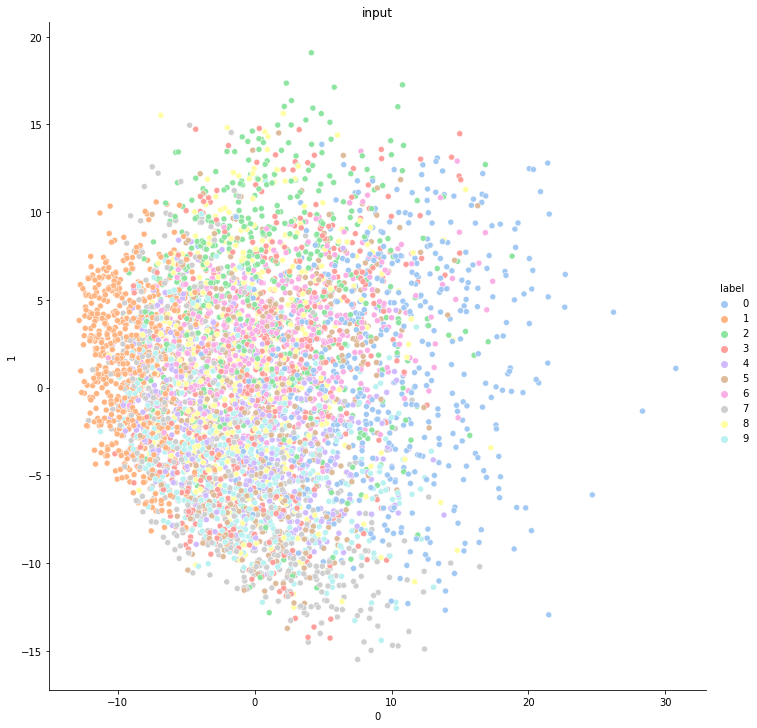

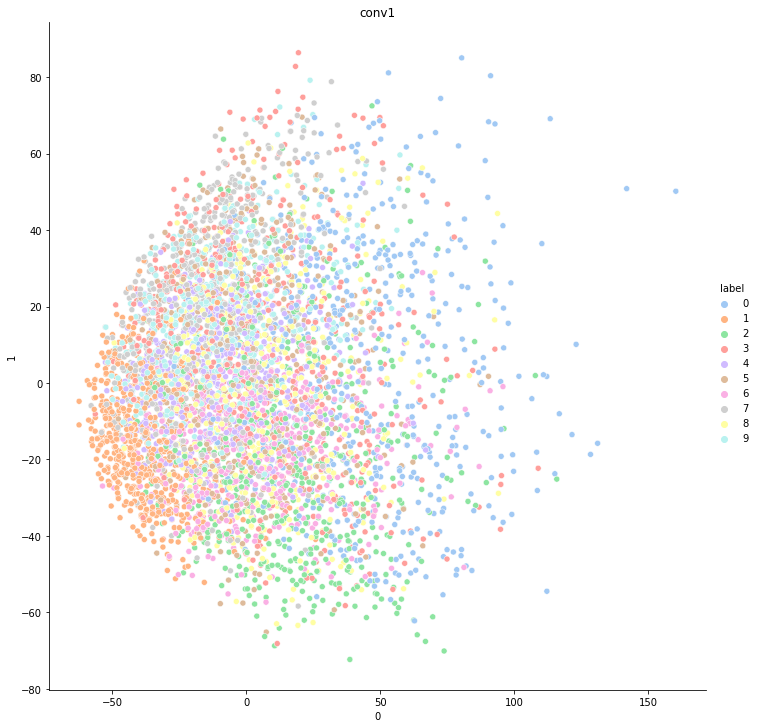

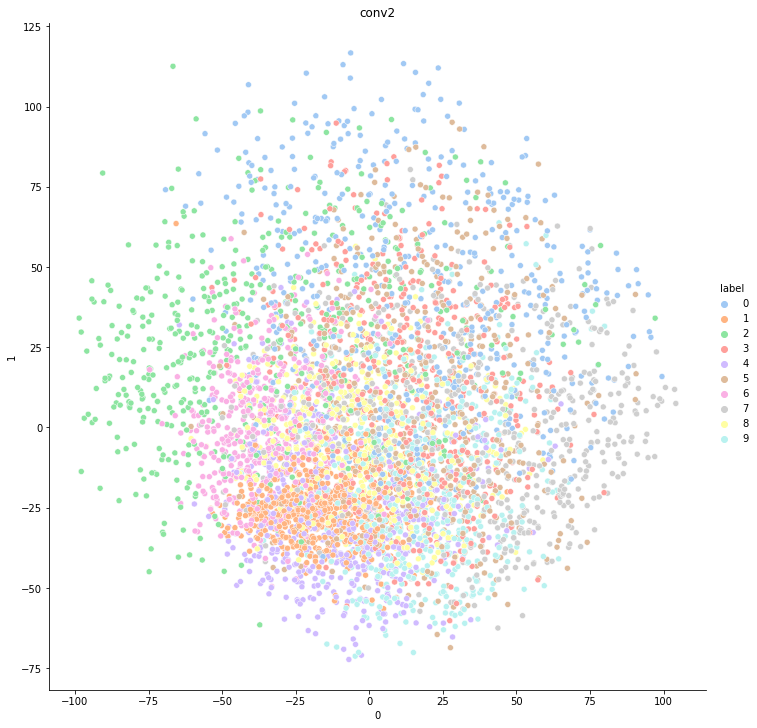

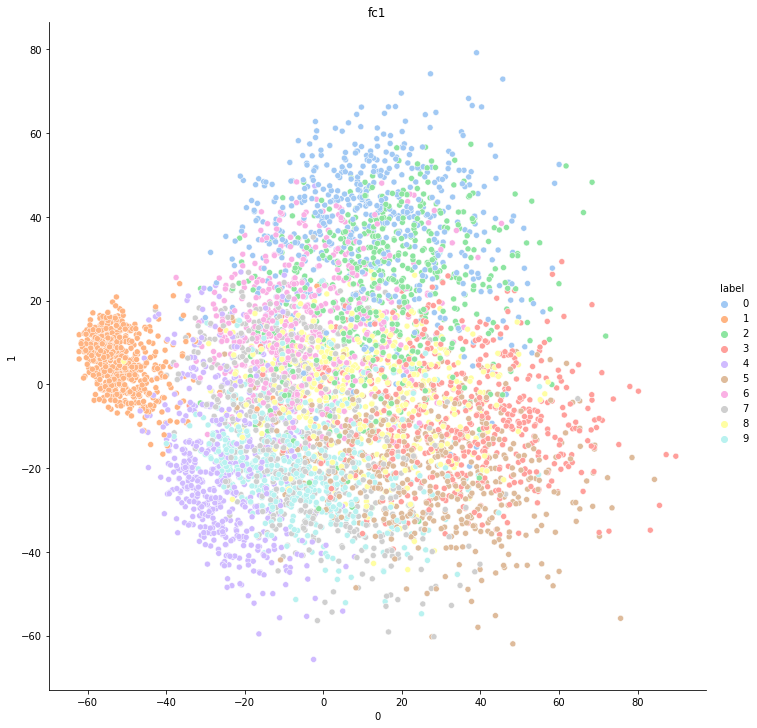

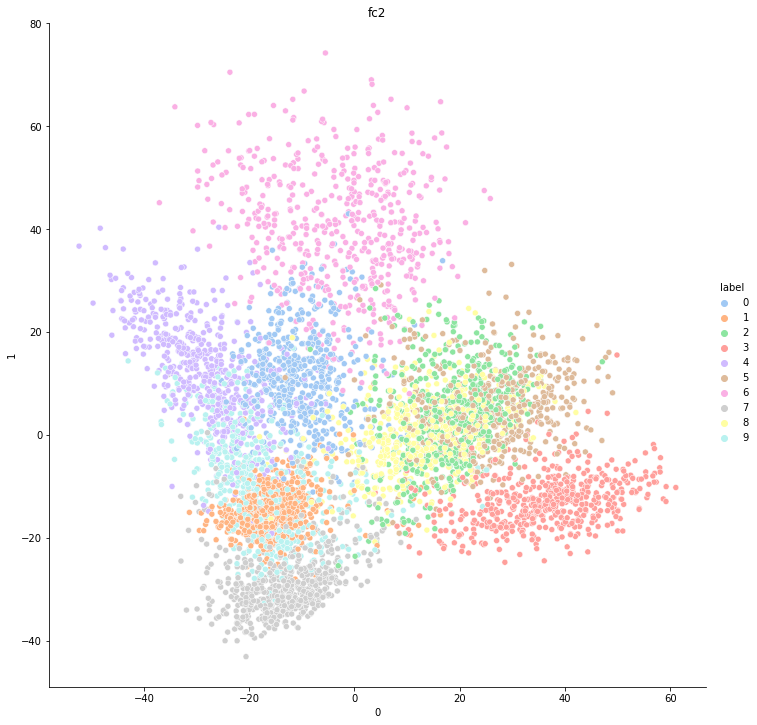

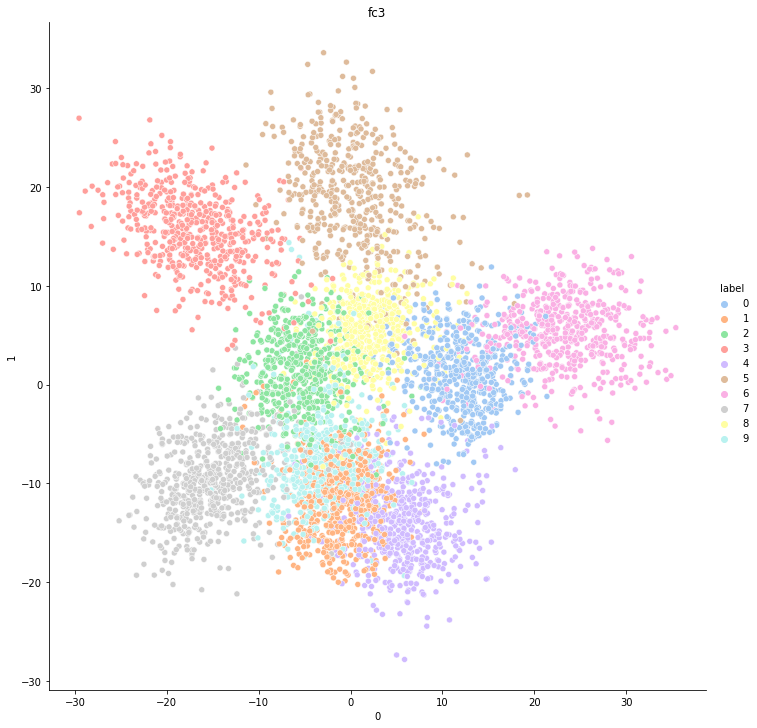

In [20]:
for feature in features.keys():
    d_prime = 2
    pca = PCA(n_components=d_prime)
    pca.fit(features[feature])
#     print(pca.components_)
#     print(pca.explained_variance_ratio_)
    Xprime = pca.transform(features[feature])
    df = pd.DataFrame(Xprime)
    df['label'] = labels
    plot = sns.relplot(x=0, y=1,hue='label',palette='pastel', height=10,data=df) 
    plot.set(title=feature)

**1.2** You'll notice that in the plot for the final feature set (`fc3`), there is still considerable overlap among points in different classses. Does this imply that if we run some kind of classification or clustering scheme on these feature vectors, we should expect it to be impossible to get very high accuracy? Why or why not?

### 1.2 Answer
We can see there are very clear clusters that each occupy a specific space that isn't too large, but there is still much overlap among these clusters. Because of that, we think it is impossible to get a very high accuracy based on only the feature set `fc3` as many images could have features that overlap with multiple clusters in `fc3`.

However, we can see that there are distinct clusters in each of the other plots, so it seems likely that the knowledge from each of these plots could be combined to predict the label with very high accuracy by cross referencing the possibilities from each plot to choose the number with the most overlap in features.

It is also possible that if we have the same feature set, `fc3`, but reduced to a greater dimensionality, 3 for example, that we could run the k means algorithm and get clearer clusters because there is greater seperation between the clusters. Transforming the data into 2 dimensions loses some of the variance of higher dimensions and thus makes it harder to form clear clusters.

#### Part 2: Estimating Intrinsic Dimensionality

Above, we used PCA to visualize how "orderly" the feature space is as it goes through the model. Now, let's look at this in a slightly more quantitative way. We talked about **intrinsic dimensionality** as the minimum number of dimensions needed to represent a set of data. PCA also gives us a coarse way to estimate the intrinsic dimensionality by looking at the amount of variance explained by each component. For example, if the vast majority of the variance is explained by the first two components, the intrinsic dimensionality is probably around 2.

**2.1**: For each of the feature sets, compute up to 100 PCA components (for features with $d < 100$, compute all $d$ components) and make a plot to visualize the fraction of the variance explained by each of the first K components as a function of K (you may find the `np.cumsum` function helpful here).

**2.2**: Let's (arbitrarily) define our estimate of intrinsic dimensionality to be the number of components needed to explain at least 90% of the variance. For each feature set, what is its intrinsic dimensionality esimate based on this definitions? Show your results in a nicely formatted table and/or a sensibly designed plot.

### Part 2 Implementation
- We make a `first90s` dictionary to store our data
- We loop over each feature
    - We set `d_prime` to be either the number of features or 100, whichever is smaller
    - We use PCA on the feature set to transform it into a shape of n x d_prime
    - We store that in a dataframe and calculate the variance of each column as a new series `variance`
    - We apply `np.cumsum()` on `variance` and store that as `cumul` to get the cumulative variance explained by each component
    - We normalize `cumul` to a scale of 1 - 100
    - We get the number of components needed to explain 90% of variance using pandas functions
    - We plot the cumulative data using Seaborn

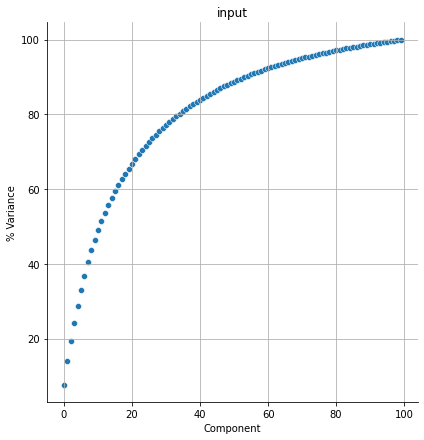

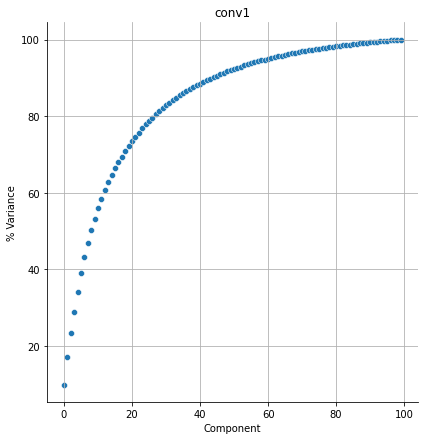

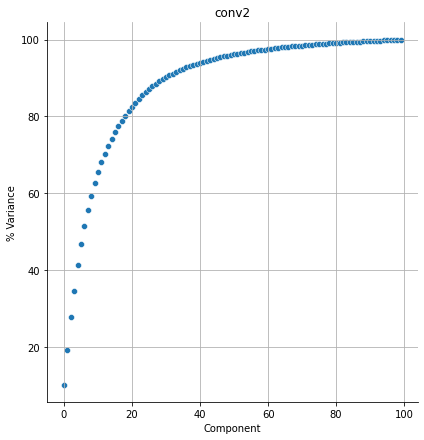

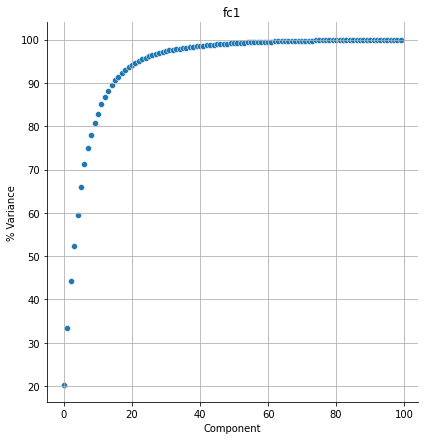

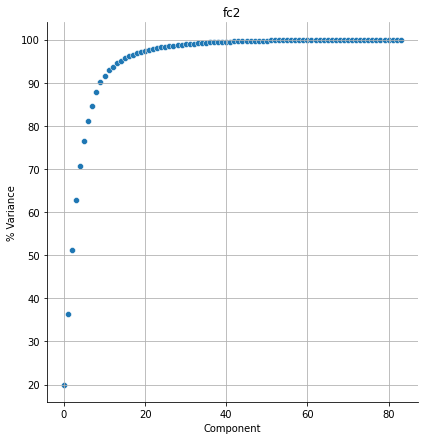

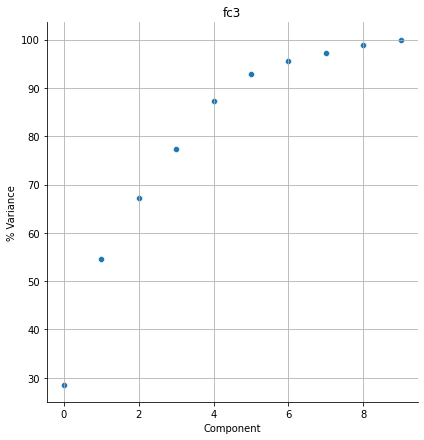

In [21]:
first90s = {}
for feature in features.keys():
    d_prime = features[feature].shape[1]
    d_prime = min(d_prime, 100)
    pca = PCA(n_components=d_prime)
    pca.fit(features[feature])

    Xprime = pca.transform(features[feature])

    df = pd.DataFrame(Xprime)
    variance = df.apply(lambda x: np.var(x))
    cumul = np.cumsum(variance)
    
#     put on 1-100 scale
    cumul = cumul * 100/max(cumul)
    df = pd.DataFrame(cumul)
    
    first90 = df[df[0] >= 90].head(1).index[0]
    first90s[feature] = first90
    
    plot = sns.relplot(
        height=6,
        data=cumul)
    plot.set(title=feature,xlabel='Component',ylabel='% Variance')
    plt.grid(which='major', alpha=1)

In [22]:
first90s = pd.DataFrame.from_dict(first90s, orient='index')
first90s

,0
input,54
conv1,44
conv2,30
fc1,15
fc2,9
fc3,5


In [23]:
columntitle = 'Components that explain 90% of variance'
first90s = first90s.rename(columns={0:columntitle})
first90s = first90s.reset_index()

### Analysis
We can see that there are quite a few components that each make a small amount of the variance as we need dozens of components to explain 90% of the variance in the first few sets. This might mean that the lack of clusters seen in the 2d graphs we plotted earlier was simply because we didn't use enough components to make out meaningful clusters in some of these feature sets.

That also explains why `fc3` and `fc2` were more clearly clustered in our plots, since they have a lower intrinsic dimensionality.

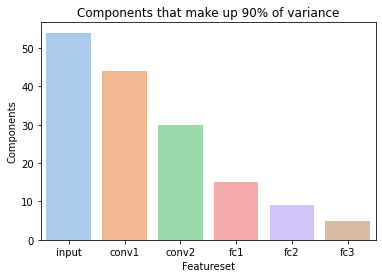

In [24]:
bar = sns.barplot(data=first90s, y=columntitle, x='index', palette='pastel');
bar.set(xlabel='Featureset', ylabel='Components', title='Components that make up 90% of variance');

#### Extra Credit

Use K-Means clustering to cluster the vectors in each feature set. Visualize the clustering results vs. the ground truth labels (you'll need to use PCA to reduce the dimensionality after clustering). Finally, calculate the percentage of digits that were assigned to a "correct" cluster. Note that since the clustering does not know anything about the actual digit labels, you'll need to find some way to establish correspondence between cluster labels and ground truth labels.